## <b><h style="color:red">第1部分</h></b>：导入IBM股价数据并简单处理

In [93]:
import pandas as pd
file = r'C:\Users\Wudey\Desktop\ChromeDownload\IBM.csv'
# 下载数据的网站：https://finance.yahoo.com/
def read_stock(file):
    x_read = pd.read_csv(file,index_col=0,parse_dates=True) # parse_dates指定日期索引，好像可以auto
    print("变量类型：\n",x_read.dtypes) # 变量类型
    # print("变量类型：\n",dta.describe())
    x_read.reset_index(inplace=True) # 将索引变成变量
    x_read["date_index"]=x_read.Date # 将变量进行复制
    x_read.set_index('Date',inplace=True) # 将复制的变量变成索引
    x_read.sort_values(by="date_index",inplace=True) # 按变量排序
    return x_read
dta=read_stock(file=file)
dta["grow_rate"]=dta['Adj Close'].pct_change() # 用adj close计算增长率
print("\n数据前2行：\n",dta.iloc[:,-4:].head(2))

变量类型：
 Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object

数据前2行：
              Adj Close   Volume date_index  grow_rate
Date                                                 
2015-05-04  139.712860  4028000 2015-05-04        NaN
2015-05-05  138.998123  3593600 2015-05-05  -0.005116


## <b><h style="color:red">第2部分</h></b>：对日收益率进行作图

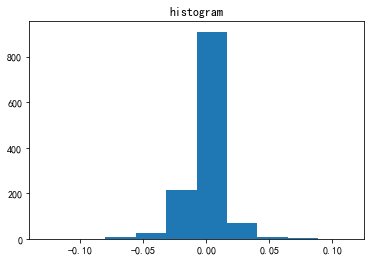

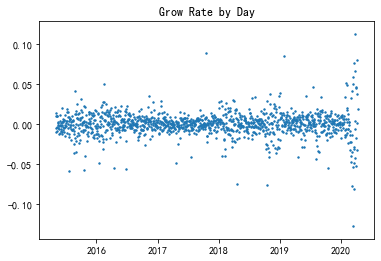

----
均值:
 8.698674205378995e-06
单样本t检验:
 Ttest_1sampResult(statistic=0.019745182249248608, pvalue=0.9842498190412305)
----
置信区间(假定正态):
 (-0.0008555991932372987, 0.0008729965416480568)


In [94]:
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
plt.hist(dta["grow_rate"][1:])
plt.title("histogram")
plt.show() # 画出来
plt.scatter(dta.date_index,dta.grow_rate,s=2.) # 散点图
plt.title("Grow Rate by Day")
plt.show()
x=dta.grow_rate[1:] # 去除缺失值
print("----\n均值:\n",np.mean(x))
print('单样本t检验:\n',stats.ttest_1samp(x,0))
print("----\n置信区间(假定正态):\n",stats.t.interval(0.95,len(x)-1,np.mean(x),stats.sem(x)))

## <b><h style="color:red">第3部分</h></b>：日收益率转化为周收益率并做图

Date数据类型：
 <class 'pandas._libs.tslibs.timestamps.Timestamp'>
----
周收益率：
最高接近15%，若能准确定位，收益很高


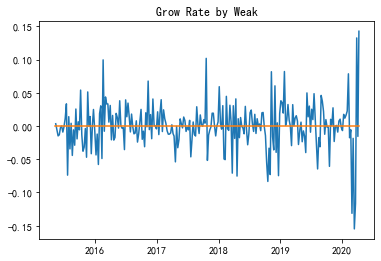

In [95]:
print("Date数据类型：\n",type(dta["date_index"][1])) # 日期格式
dta_m=dta.resample('W',on='date_index').last() # 每周最后一天“调整收盘价”（周五）,也可以取月最后一天
dta_m.rename(columns={"date_index":"Date"},inplace=True) # 前一句让index名变成了date_index
# 另一种处理方式，比较慢
# dta_temp=dta_m.to_period("M")
# print("索引转成月：\n",dta_temp.iloc[1:2,0:3]) # 若需要对“月”处理，可以将index变成月份，再展开,注意这个操作会重置index的名称，这里不再论述
dta_m["grow_rate_weak"]=dta_m['Adj Close'].pct_change()
plt.plot(dta_m.Date,dta_m.grow_rate_weak)
plt.plot(dta_m.Date,[0 for i in range(0,len(dta_m.Date))])
plt.title("Grow Rate by Weak")
plt.show()
print("----\n周收益率：\n最高接近15%，若能准确定位，收益很高")

## <b><h style="color:red">第4部分</h></b>：策略

----
若随意购买IBM，任意持有1周，约收益0.002%，非常的少(约为余额宝的60%)
----
引入Apple股票
----
变量类型：
 Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object
----
若随意购买Apple，任意持有1周，约收益0.3937%，很高
----


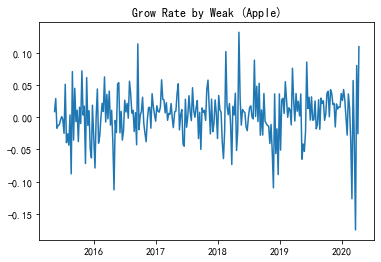

In [96]:
print('----\n若随意购买IBM，任意持有1周，约收益%.3f%%，非常的少(约为余额宝的60%%)\n----' % np.mean(dta_m["grow_rate_weak"]*100))
print('引入Apple股票\n----')
file = r'C:\Users\Wudey\Desktop\ChromeDownload\AAPL.csv'
dta_apple=read_stock(file)
dta_m_apple=dta_apple.resample('W',on='date_index').last()
dta_m_apple.rename(columns={"date_index":"Date"},inplace=True) 
dta_m_apple["grow_rate_weak"]=dta_m_apple['Adj Close'].pct_change()
dta_m["ind"]="IBM"
dta_m_apple["ind"]="apple"
dta_two=pd.concat([dta_m,dta_m_apple]) # 简单合并，类似于R语言中的rbind和cbind
print('----\n若随意购买Apple，任意持有1周，约收益%.4f%%，很高\n----' % np.mean(dta_m_apple["grow_rate_weak"]*100))
plt.plot(dta_m_apple.Date,dta_m_apple.grow_rate_weak)
plt.title("Grow Rate by Weak (Apple)")
plt.show()

- <b><h style="color:red">Q1</h></b>：Apple的周平均收益率是IBM的10倍多，是否就意味着Apple收益比IBM高？

In [97]:
import statsmodels.stats.anova as anova
from statsmodels.formula.api import ols
# 方差分析
model=ols('grow_rate_weak~C(ind)',data=dta_two).fit()
print("单因素方差分析：\n",anova.anova_lm(model),
      "\n####多因素方差分析，两个因子变量即可",
      "\n####析因方差分析，两个因子变量相乘即可",
      "\n>看一个变量的影响是否受到另一个变量的影响\n----")
print("即使两者周收益均值差别很大，"
      "\n>但是方差分析表明没有显著区别，\n>说明波动（组内差异）非常大\n----")
# 大胆假设两个股票是有关系的

单因素方差分析：
              df    sum_sq   mean_sq         F    PR(>F)
C(ind)      1.0  0.001970  0.001970  1.487048  0.223237
Residual  512.0  0.678238  0.001325       NaN       NaN 
####多因素方差分析，两个因子变量即可 
####析因方差分析，两个因子变量相乘即可 
>看一个变量的影响是否受到另一个变量的影响
----
即使两者周收益均值差别很大，
>但是方差分析表明没有显著区别，
>说明波动（组内差异）非常大
----


### 用回归来看两者关系

相关系数：
                   grow_rate_weak_y  grow_rate_weak_x
grow_rate_weak_y          1.000000          0.478703
grow_rate_weak_x          0.478703          1.000000
----
OLS回归：
                             OLS Regression Results                            
Dep. Variable:       grow_rate_weak_y   R-squared:                       0.229
Model:                            OLS   Adj. R-squared:                  0.226
Method:                 Least Squares   F-statistic:                     75.81
Date:                Wed, 13 May 2020   Prob (F-statistic):           3.99e-16
Time:                        19:34:51   Log-Likelihood:                 508.01
No. Observations:                 257   AIC:                            -1012.
Df Residuals:                     255   BIC:                            -1005.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    

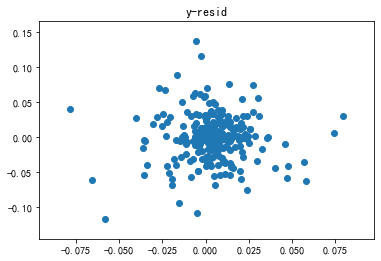

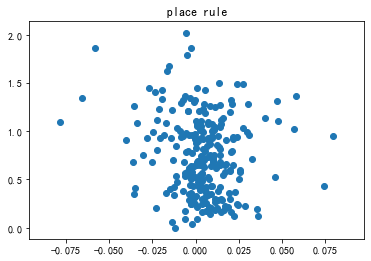

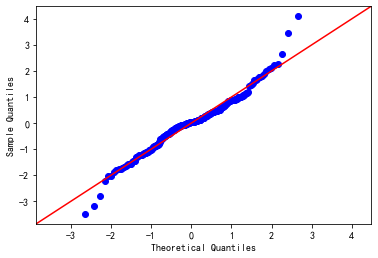

In [98]:
# 回归分析
import statsmodels.api as sm
dta_two_col=pd.merge(dta_m,dta_m_apple,"inner",on="Date")
print("相关系数：\n",dta_two_col.loc[:,("grow_rate_weak_y","grow_rate_weak_x")].corr())
model=ols("grow_rate_weak_y~grow_rate_weak_x",dta_two_col).fit()
print("----\nOLS回归：\n",model.summary())
plt.scatter(model.fittedvalues,model.resid)
plt.title("y-resid")
plt.show()
plt.scatter(model.fittedvalues,(model.resid_pearson**2)**0.25)
plt.title("place rule")
plt.show()
sm.qqplot(model.resid_pearson,stats.norm,line='45') # 标准化残差
print('----\nQQ图：两侧偏离（尖端后尾），不满足正态性\n----')
print('位置尺图：同方差应该是水平、宽度一致的条带；基本满足\n----')
# 多元回归
# sm.OLS(dta_m.grow_rate_weak,sm.add_constant(dta_m[:,-3:])).fit()
# 该回归无意义，不运行，仅仅用来表明多元回归的写法

## 风险
- [X] 风险类型
>- [ ] <b><h style="color:red">利率风险：</h></b>利率变动会对所有需要融资的企业造成风险
>- [ ] <b><h style="color:red">汇率风险：</h></b>汇率会对净出口较大的企业造成风险
>- [ ] <b><h style="color:red">流动性风险：</h></b>流动性会对买方造成风险（无法脱手），对股票来说，即成交量，如当企业财务出现问题时，可能天天跌停，购买方无法卖出变现
>- [ ] <b><h style="color:red">信用风险：</h></b>公司可能会因为财政问题或者失信不能偿还本金和利息，在购买公司债券时，需要注意防范，查看公司财务报表，看经营状况
>- [ ] <b><h style="color:red">通货膨胀风险：</h></b>通货膨胀会影响投资人需求，一般影响长期投资
- [X] 风险测量
>- [ ] 可以用收益率的标准差测量风险，后来有人提出低于无风险收益或者低于0的才算风险（下行风险）
>- [X] VaR风险价值：95%的可能性最大下跌，可用历史模拟法、协方差矩阵和蒙特卡洛模拟来计算
>>- 历史模拟法：grow_rate.quantile(0.05) # pandas
>>- 协方差矩阵法：ppf(0.05,grow_rate.mean(),grow_rate.std()) # scipy.stats.norm
>- [ ] 期望亏空(弥补VaR理论缺陷)：grow_rate[grow_rate<=grow_rate.quantile(0.05)].mean()
>- [ ] 最大回测（最大亏损）率：最大回测是指某时间段T内最大损失率MD(正)，MDR=MD/(MD+R(t)),ffn.calc_max_drawdown((1+grow_rate).cumprod())
>- [ ] CAPM模型，回归Ri-Rf=a+b(Rm-Rf)+ui，其中Rf为无风险收益，Rm为大盘收益，b>1表明i的波动率大于m，CAPM的Beta值非常不确定，不同时期值差异大。CAPM一般用于寻找跑赢大盘的股票（a显著>0），适用于中长期
>- [ ] 三因子模型（CAPM+3自变量），《量化投资以Python为工具》P308
>

C:\wudeyuan\Anaconda\lib\site-packages\statsmodels\tsa\stattools.py:572: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning


自相关系数：
 [ 1.         -0.06187483  0.10363495 -0.01144976  0.0866239 ]
自相关系数：
 [ 1.00000000e+00 -6.21165303e-02  1.00978935e-01  5.27648205e-04
  7.79206925e-02]
----
ADF检验(单位根)：
    Augmented Dickey-Fuller Results   
Test Statistic                -16.730
P-value                         0.000
Lags                                0
-------------------------------------

Trend: Constant
Critical Values: -3.46 (1%), -2.87 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.
----
白噪声检验（自相关）：
 备择假设是存在自相关（第二个array是p值，看最后一个），白噪声数据理论上是无法预测的
 (array([ 0.99545351,  3.79898352,  3.8333387 ,  5.80752341,  7.64160773,
        7.64418551,  8.62658616,  8.78118898,  8.79375495,  8.95761613,
        9.92547291, 11.34014602]), array([0.31841313, 0.14964466, 0.28003202, 0.21399105, 0.17712485,
       0.26534697, 0.28058851, 0.36108966, 0.4565263 , 0.53613065,
       0.53710316, 0.50001485]))


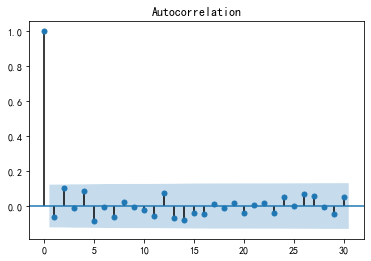

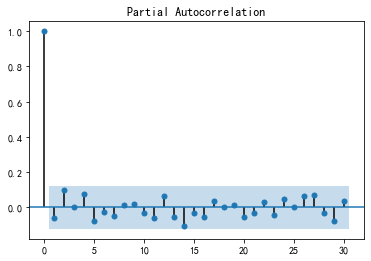

In [99]:
# 自相关系数跟一般相关系数一样，偏自相关系数是排除了其它相关系数的影响，如xt与xt-k的偏相关排除了xt-1到xt-k-1的影响
from statsmodels.tsa import stattools
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
print("自相关系数：\n",stattools.acf(dta_m_apple.grow_rate_weak[1:])[:5]) # 自相关系数
print("自相关系数：\n",stattools.pacf(dta_m_apple.grow_rate_weak[1:])[:5]) # 偏自相关系数
plot_acf(dta_m_apple.grow_rate_weak[1:],use_vlines=True,lags=30)
plot_pacf(dta_m_apple.grow_rate_weak[1:],use_vlines=True,lags=30)
# 平稳性（弱平稳）：方差、均值不随时间改变
# d次差分平稳，称为I(d)
from arch.unitroot import ADF
adf=ADF(dta_m_apple.grow_rate_weak[1:])
print("----\nADF检验(单位根)：\n",adf.summary()) # 平稳性检验
rk=dta_m_apple.grow_rate_weak[1:]
print("----\n白噪声检验（自相关）：\n",
      "备择假设是存在自相关（第二个array是p值，看最后一个），白噪声数据理论上是无法预测的\n",
      stattools.q_stat(stattools.acf(rk)[1:13],len(rk)))

## 时间序列的预测
- [ ] <b><h style="color:red">AR(p)模型：</h></b>自回归，自变量滞后模型，xt与xt-h的相关系数会随着h增加逐渐减少，h>p后仍不会等于0
- [ ] <b><h style="color:red">MA(q)模型：</h></b>移动平均模型，误差项滞后模型，xt与xt-h的相关系数在h>q后截断，等于0
- [X] <b><h style="color:red">ARMA(p,q)模型：</h></b>自回归移动平均模型，自变量和误差项都滞后，建模步骤如下：
>- [ ] 序列识别，1.是否平稳（不平稳则转为平稳），2.是否是白噪声，是则结束，否则下一步
>- [ ] 确定p和q的值，可以先看acf和pcf图，再根据模型拟合指标的AIC和BIC来确定
>- [ ] 残差检验，是否是正态分布的白噪声
>- [X] 可以看出ARMA的<b><h style="color:blue">假设很严格</h></b>。


----
ADF检验(单位根)：
    Augmented Dickey-Fuller Results   
Test Statistic                 -8.691
P-value                         0.000
Lags                                4
-------------------------------------

Trend: Constant
Critical Values: -3.46 (1%), -2.87 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.
----
白噪声检验（自相关）：
 (array([ 0.59269419,  9.56412371, 11.16180121, 15.34406692, 19.40601472,
       21.06035978, 21.46846803, 22.22429892, 22.65544362, 23.34955857,
       25.01561098, 25.88255383]), array([0.44137918, 0.00837871, 0.01088237, 0.00403831, 0.00161451,
       0.00178936, 0.00313527, 0.00451687, 0.00701831, 0.0095273 ,
       0.00906883, 0.01115209]))
----
AR(p): ACF拖尾，PACF p阶截尾 
MA(q): ACF q阶截尾，PACF拖尾 
ARMA(p): 拖尾(符合图形结果)
----
ARMA(1,1)结果： 
调整order的参数，获取不同结果，比较AIC和BIC指标，得到最优拟合，最优恰好是1，1 
还可以用stattools.arma_order_select_ic(dt=data,max_ma=4)来筛选
                               ARMA Model Results    

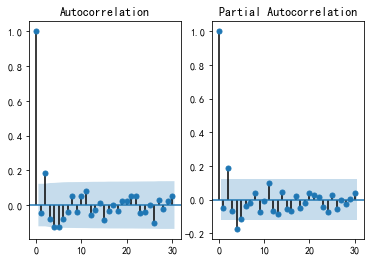

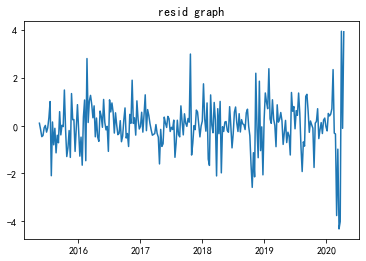

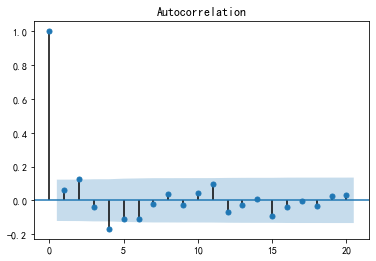

In [100]:
# 已经确定过apple是白噪声，无法建模，这里用IBM再尝试建模
adf=ADF(dta_m.grow_rate_weak[1:])
print("----\nADF检验(单位根)：\n",adf.summary()) # 平稳性检验
rk=dta_m.grow_rate_weak[1:]
print("----\n白噪声检验（自相关）：\n",
      stattools.q_stat(stattools.acf(rk)[1:13],len(rk)))
# 平稳的，且并非白噪声
axe1=plt.subplot(121)
axe2=plt.subplot(122)
dta_arma=dta_m.grow_rate_weak[1:]
plot1=plot_acf(dta_arma,lags=30,ax=axe1)
plot2=plot_pacf(dta_arma,lags=30,ax=axe2)
plt.show()
print("----\nAR(p): ACF拖尾，PACF p阶截尾",
      "\nMA(q): ACF q阶截尾，PACF拖尾",
      "\nARMA(p): 拖尾(符合图形结果)")
from statsmodels.tsa import arima_model
model=arima_model.ARIMA(dta_arma,order=(1,0,1)).fit()
print("----\nARMA(1,1)结果：",
      "\n调整order的参数，获取不同结果，比较AIC和BIC指标，得到最优拟合，最优恰好是1，1",
      "\n还可以用stattools.arma_order_select_ic(dt=data,max_ma=4)来筛选\n",
      model.summary())
import math
resid=model.resid/math.sqrt(model.sigma2)
plt.plot(resid) # 标准化残差图
plt.title("resid graph")
plt.show()
print("----\n残差基本在+3和-3之间，偏差值较少",
      "\nacf图显示，4阶相关系数是显著的",
      "\nLB检验，并非白噪声",
      "\n用季节性ARIMA模型，LB检验表明是白噪声",)
plot_acf(resid,lags=20)
LjungBox=stattools.q_stat(stattools.acf(resid)[1:13],len(resid))
print("LB检验: ",LjungBox[1][-1])
import statsmodels.api as sm
model=sm.tsa.statespace.SARIMAX(dta_arma,order=(1,0,1),seasonal_order=(1,0,1,4)).fit()
print("----\n季节性ARMA(1,1)结果：",
      model.summary())
resid=model.resid
LjungBox=stattools.q_stat(stattools.acf(resid)[1:7],len(resid))
print("LB检验(加入季节性): ",LjungBox[1][-1])

## LB检验只能确定不是白噪声（p<0.05）和不拒绝是白噪声(p>0.1)，即可能没有完全挖掘出信息，基于此，研究发现：
- [ ] 收益率自相关一般比较弱，但是它变换（平方、绝对值等）后的相关性很强
- [ ] 收益率的条件方差可能会随时间改变，即条件异方差
- [ ] 收益率会呈现波动聚集，大（小）波动跟大（小）波动
- [ ] 收益不服从正态分布，而是后尾

## 用波动率模型拟合上述特征，用以1）使回归参数更具有效性，2）判断交易风险
- [ ] arch(p)模型是对误差项进行建模，假设AR(1)的误差项位ut，根据第3条，假设μt=σt\*ut，σt^2=α0+...+αp*μ(t-p)^2，可以证明μt是白噪声，但是μt|y(t-1)的方差会随着t变化。类似于的AR思想。
- [ ] arch(p)模型假定σt^2与μt^2的前p期有关，garch(p,q)模型扩展了这个假定，它假设σt^2还与σt^2的前q期有关。类似于ARMA思想。
- [ ] arch和garch都有后尾特征，但是这两个模型的假定也比较严格，实证中系数如α不是固定的，如会受到好坏消息的影响，后续该模型的扩展渐渐解决了这个问题。此外，理论性较弱，仅仅是拟合结果。
- [ ] 以下将IBM收益率平方项作为波动率代理变量，观察是否存在arch效应，并构建garch模型。garch模型中有一个均值模型（默认AR(0)），python似乎不能修改默认模型，即arch包只能直接联合AR(0)和GARCH模型，我们借用R语言中的包来联合ARMA和GARCH模型。

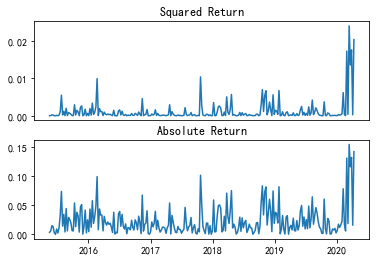

----
从图中可以看出有波动聚集现象，可能有arch效应
LB检验： 1.8007963427221258e-22 
非白噪声，确实有arch效应，这里不再探索具体是什么形式 
以下进行garch模型拟合，注意，它只看误差项，arch_model不能直接设定ARIMA模型

# R包：rugarch

ugarchspec(

variance.model = list(model = "sGARCH", garchOrder = c(1,1)),

mean.model = list(armaOrder = c(1,1), include.mean = F),

distribution.model = "std"

)

# 注意：不能直接拟合ARIMA(p,d,q)差分(d>0)模型，即差分到平稳这个过程需要自己动手

# 参考https://www.rdocumentation.org/packages/rugarch/versions/1.4-2/topics/ugarchspec-methods



In [101]:
# arch效应
plt.subplot(211)
plt.plot(dta_arma**2)
plt.title('Squared Return')
plt.xticks([])
plt.subplot(212)
plt.plot(np.abs(dta_arma))
plt.title('Absolute Return')
plt.show()
print("----\n从图中可以看出有波动聚集现象，可能有arch效应")
LjungBox=stattools.q_stat(stattools.acf(dta_arma**2)[1:13],len(dta_arma))
print("LB检验：",LjungBox[1][-1],
      "\n非白噪声，确实有arch效应，这里不再探索具体是什么形式",
      "\n以下进行garch模型拟合，注意，它只看误差项，arch_model不能直接设定ARIMA模型")
# garch模型
print('''
# R包：rugarch\n
ugarchspec(\n
variance.model = list(model = "sGARCH", garchOrder = c(1,1)),\n
mean.model = list(armaOrder = c(1,1), include.mean = F),\n
distribution.model = "std"\n
)\n
# 注意：不能直接拟合ARIMA(p,d,q)差分(d>0)模型，即差分到平稳这个过程需要自己动手\n
# 参考https://www.rdocumentation.org/packages/rugarch/versions/1.4-2/topics/ugarchspec-methods
''')

## 策略
- [ ] 配对：选择两个相关性很高的股票，赚差价（价差较大时买空，较小是买入）

---
距离： 100.89468082515543
---
单位根检验（IBM，较为平稳，差分后平稳）：
    Augmented Dickey-Fuller Results   
Test Statistic                 -2.743
P-value                         0.067
Lags                                5
-------------------------------------

Trend: Constant
Critical Values: -3.46 (1%), -2.87 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.
---
单位根检验（Apple,差分后平稳）：
    Augmented Dickey-Fuller Results   
Test Statistic                 -0.258
P-value                         0.931
Lags                                0
-------------------------------------

Trend: Constant
Critical Values: -3.46 (1%), -2.87 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.
---
从图来看，差分后是都是平稳的 
回归结果非常显著 
回归残差是平稳的，说明两者对数价格是协整的
                            OLS Regression Results                            
Dep. Variable:              Adj Close   R-squared: 

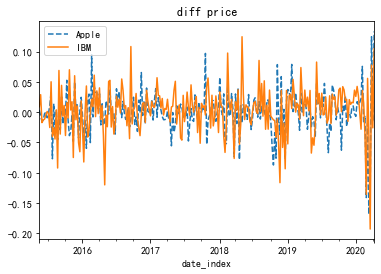

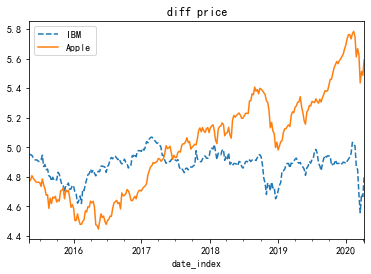

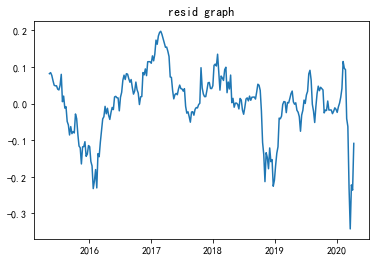

C:\wudeyuan\Anaconda\lib\site-packages\arch\unitroot\unitroot.py:465: FutureWarning: Trend "nc" is deprecated and has been replaced with "n" (for none).
  FutureWarning,


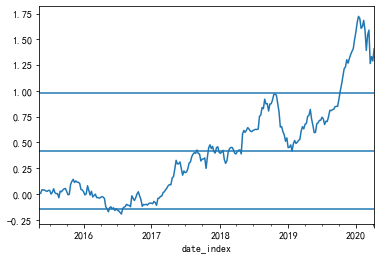

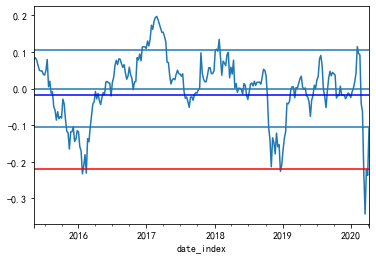

In [102]:
# 寻找配对（最小距离）
def ssd(returnA,returnB):
    staX=(returnA+1).cumprod() # cumprod()会去除缺失值
    staY=(returnB+1).cumprod()
    ssd=np.sum((staX-staY)**2)
    return(ssd)
print("---\n距离：",ssd(dta_m_apple.grow_rate_weak,dta_m.grow_rate_weak))
# 协整模型
pA=np.log(dta_m["Adj Close"])
pB=np.log(dta_m_apple["Adj Close"])
print("---\n单位根检验（IBM，较为平稳，差分后平稳）：\n",ADF(pA))
print("---\n单位根检验（Apple,差分后平稳）：\n",ADF(pB))
pB=pB.diff()[1:]
ADF(pB)
pA=pA.diff()[1:]
ADF(pA)
print("---\n从图来看，差分后是都是平稳的",
      "\n回归结果非常显著",
      "\n回归残差是平稳的，说明两者对数价格是协整的")
pA.plot(label='Apple',style='--')
pB.plot(label='IBM',style='-')
plt.legend(loc='upper left')
plt.title('diff price')
plt.show()
np.log(dta_m["Adj Close"]).plot(label='IBM',style='--')
np.log(dta_m_apple["Adj Close"]).plot(label='Apple',style='-')
plt.legend(loc='upper left')
plt.title('diff price')
plt.show()
model=sm.OLS(np.log(dta_m["Adj Close"]),sm.add_constant(np.log(dta_m_apple["Adj Close"]))).fit()
print(model.summary())
plt.plot(model.resid)
plt.title('resid graph')
plt.show()
ADF(model.resid,trend='nc')
# 假设现在找到了配对股票（最小价差）
# 价差策略
sta_apple=(dta_m_apple.grow_rate_weak+1).cumprod() # 也可以用对数收益率
sta_IBM=(dta_m.grow_rate_weak+1).cumprod()
SSD_pair=sta_apple-sta_IBM # 价差
spaceU=np.mean(SSD_pair)+1.2*np.std(SSD_pair) # 1.2根据实际情况修改
spaceL=np.mean(SSD_pair)-1.2*np.std(SSD_pair)
SSD_pair.plot()
plt.axhline(y=spaceU)
plt.axhline(y=np.mean(SSD_pair))
plt.axhline(y=spaceL)
plt.show() # 价差策略图，效果以前非常好，但是后来很差，可能是没选好配对股票
# 协整策略
model.resid.plot()
plt.axhline(y=np.mean(model.resid)-1.2*np.std(model.resid))
plt.axhline(y=np.mean(model.resid)-0.2*np.std(model.resid),color='blue')
plt.axhline(y=np.mean(model.resid)-2.5*np.std(model.resid),color='red') # 强制平仓
plt.axhline(y=np.mean(model.resid))
plt.axhline(y=np.mean(model.resid)+1.2*np.std(model.resid))
plt.show() # 协整看起来比价差靠谱
# 正负0.2*std期间时，买入之前卖出的股票，再买入两种股票，维持资金比例位beta（系数，不知道怎么算的这个配比）

## 技术指标和量化投资
- [ ] K线图的形状信号
- [ ] 动量理论（慎用）；RSI比较买卖方力量（还行），黄金交叉（慎用）。
- [X] 移动平均：直接看没有什么作用，交叉线还行
>- [ ] MACD: 对于波动较大的股票，效果不佳，这种情况下，可能长线较好

C:\wudeyuan\Anaconda\lib\site-packages\pandas\core\indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\wudeyuan\Anaconda\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


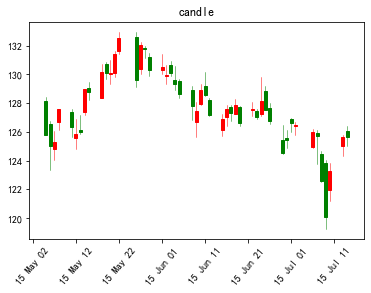

---
反转信号：1跌2小跌(十字星)3涨(3绝对值大于等于1的一半)，涨小跌(十字星)跌 
下跌信号：第一天涨较多，第二天小涨再下跌较多，下跌越多市场越不行 
以上只是市场信号，具体怎么变结合股价具体价格，怎么找到这些形状可以自己想办法 
---
动量理论：个人认为动量理论不适合做投资，且市场表现预计不佳，书上虽有提及，这里不做讨论 
---
RSI相对强弱指标：之前几期的买方和卖方平均力量来预测股价变化 
移动平均：仅仅从均线来看，对于波动较大的股票，很难看到投资机会
 交叉：短期均线和长期均线交叉点来看投资机会，机会较少，总体还行


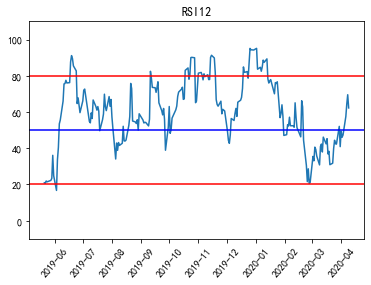

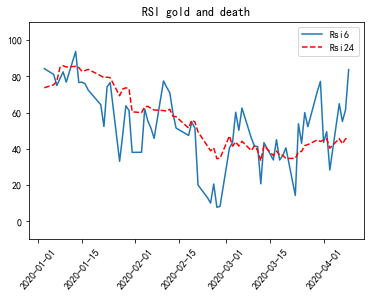

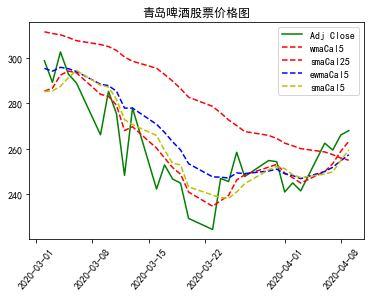

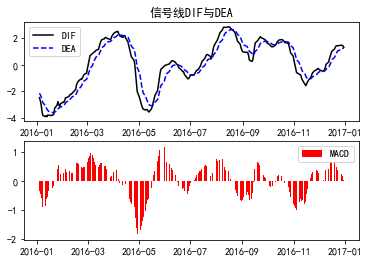

In [103]:
from matplotlib.dates import DateFormatter,date2num
from mpl_finance import candlestick_ohlc
def candlePlot(seriesData,title="candle"): # 画图的函数
	#设定日期格式
    Date=[date2num(date) for date in seriesData.index]
    seriesData.loc[:,'Date']=Date
    # 转数据格式
    listData=[]
    for i in range(len(seriesData)):
        a=[seriesData.loc[:,"Date"][i],seriesData.loc[:,"Open"][i],
           seriesData.loc[:,"High"][i],seriesData.loc[:,"Low"][i],seriesData.loc[:,"Close"][i]]
        listData.append(a)
	#设定绘图相关参数
    ax = plt.subplot()
    weekFormatter = DateFormatter('%y %b %d') #日期格式为‘15-Mar-09’形式
    ax.xaxis.set_major_formatter(weekFormatter)
	#调用candlestick_ohlc函数
    candlestick_ohlc(ax,listData, width=0.7,colorup='r',colordown='g')
    ax.set_title(title) #设定标题
    #设定x轴日期显示角度
    plt.setp(plt.gca().get_xticklabels(),rotation=50,horizontalalignment='center')
    return(plt.show())
candlePlot(dta_apple.iloc[1:50,:])
print("---\n反转信号：1跌2小跌(十字星)3涨(3绝对值大于等于1的一半)，涨小跌(十字星)跌",
      "\n下跌信号：第一天涨较多，第二天小涨再下跌较多，下跌越多市场越不行",
      "\n以上只是市场信号，具体怎么变结合股价具体价格，怎么找到这些形状可以自己想办法",
      "\n---\n动量理论：个人认为动量理论不适合做投资，且市场表现预计不佳，书上虽有提及，这里不做讨论",
      "\n---\nRSI相对强弱指标：之前几期的买方和卖方平均力量来预测股价变化",
      "\n移动平均：仅仅从均线来看，对于波动较大的股票，很难看到投资机会\n",
      "交叉：短期均线和长期均线交叉点来看投资机会，机会较少，总体还行")

# RSI相对强弱指标
# 买方和卖方力量的消长会影响股票价格
price_change=dta_apple['Adj Close']['2019-05-03':].diff().dropna()
def rsi(clprcChange,period=6):
    indexprc=clprcChange.index
    upPrc=pd.Series(0,index=indexprc) # 构建0序列
    upPrc[clprcChange>0]=clprcChange[clprcChange>0] # 挑出>0，并赋值
    downPrc=pd.Series(0,index=indexprc)
    downPrc[clprcChange<0]=-clprcChange[clprcChange<0]  # 挑出<0，并赋值
    SMUP=[]; SMDOWN=[]
    for i in range(period,len(upPrc)+1): # 前6日均值
        SMUP.append(np.mean(upPrc.values[(i-period):i],dtype=np.float32))
        SMDOWN.append(np.mean(downPrc.values[(i-period):i],dtype=np.float32))
    rsi=[100*SMUP[i]/(SMUP[i]+SMDOWN[i]) for i in range(0,len(SMUP))]
    indexRsi=indexprc[(period-1):]
    rsip=pd.Series(rsi,index=indexRsi)
    return(rsip)
Rsi6=rsi(price_change,6)
Rsi12=rsi(price_change,12)
Rsi24=rsi(price_change,24)
plt.plot(Rsi12)
plt.title('RSI12')
plt.ylim(-10,110)
plt.axhline(y=80,color='red')
plt.axhline(y=50,color='blue')
plt.axhline(y=20,color='red')
plt.xticks(rotation=50)
plt.show()
#黄金交叉与死亡交叉(不太准，慎用)
plt.plot(Rsi6['2020-01-03':],label="Rsi6")
plt.plot(Rsi24['2020-01-03':],label="Rsi24",color='red',linestyle='dashed')
plt.title("RSI gold and death")
plt.ylim(-10,110)
plt.xticks(rotation=50)
plt.legend()
plt.show()

# 移动平均
# 简单移动平均
def smaCal(tsPrice,k):
    Sma=pd.Series(0.0,index=tsPrice.index)
    for i in range(k-1,len(tsPrice)):
        Sma[i]=sum(tsPrice[(i-k+1):(i+1)])/k
    return(Sma)
md=smaCal(dta_apple['Adj Close'],5)
md1=smaCal(dta_apple['Adj Close'],25)
# 加权移动平均
def wmaCal(tsPrice,weight):
    '''可以根据时间获取权重，dayi/sum(day)'''
    k=len(weight)
    arrWeight=np.array(weight)
    Wma=pd.Series(0.0,index=tsPrice.index)
    for i in range(k-1,len(tsPrice.index)):
       Wma[i]=sum(arrWeight*tsPrice[(i-k+1):(i+1)])
    return(Wma)
wgt=np.array([1,2,3,4,5])
w=wgt/sum(wgt)
wd=wmaCal(dta_apple['Adj Close'],w)
# 指数加权平均,类似泰勒展开
def ewmaCal(tsprice,period=5,exponential=0.2):
    '''period较大时(>7)，exponential=2/(1+period)'''
    Ewma=pd.Series(0.0,index=tsprice.index)
    Ewma[period-1]=np.mean(tsprice[0:period]) # 前几期的简单平均
    for i in range(period,len(tsprice)):
       Ewma[i]=exponential*tsprice[i]+(1-exponential)*Ewma[i-1]
    return(Ewma)
ewd=ewmaCal(dta_apple['Adj Close'])

plt.rcParams['font.sans-serif'] = ['SimHei']
plt.plot(dta_apple['Adj Close']['2020-03-01':],label="Adj Close",color='g')
plt.plot(wd['2020-03-01':],label="wmaCal5",color='r',linestyle='dashed')
plt.plot(md1['2020-03-01':],label="smaCal25",color='r',linestyle='dashed')
plt.plot(ewd['2020-03-01':],label="ewmaCal5",color='b',linestyle='dashed')
plt.plot(md['2020-03-01':],label="smaCal5",color='y',linestyle='dashed')
plt.title("青岛啤酒股票价格图")
plt.xticks(rotation=50)
plt.legend()
plt.show()

# MACD
# 离差值IDF（快速线）：EMA(12)-EMA(26)
# DEA（慢速线）：EMA(DIF,9)，DIF值的9日指数移动平均
# MACD=DIF-DEA
DIF=ewmaCal(dta_apple['Adj Close'],12,2/(1+12))-ewmaCal(dta_apple['Adj Close'],26,2/(1+26))
DEA=ewmaCal(DIF,9,2/(1+9))
MACD=DIF-DEA
# MACD图
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False  # 负号乱码，加上这一句
plt.subplot(211)
plt.plot(DIF['2016'],label="DIF",color='k')
plt.plot(DEA['2016'], label="DEA",color='b',linestyle='dashed')
plt.title("信号线DIF与DEA")
plt.legend()
plt.subplot(212)
plt.bar(MACD['2016'].index,height=MACD['2016'],label='MACD',color='r')
plt.legend()
plt.show()

- [X] 通道突破策略
>- [ ] 唐奇安（Donchian Channel）：20天内最大价格（High）和最小价格以及均值
>- [ ] 布林带通道（Bollinger Band）：按照分布的理念来设计，也不是那么靠谱，因为它虽然可能可以比较有效的估计股价会回到均线，但是均线是变化的，作用有限。
- [ ] 随机指标(KDJ):衡量当前价格在近n天价差的位置，原理在于假设近期股票的震荡是随机的
- [ ] 量（成交量）价关系：价涨量增
- [ ] OBV指标：交易能量潮，策略是OBV增加时，累计成交量增加，短期内，价格可能继续上涨。对于波动较大的股票，很难判断。

C:\wudeyuan\Anaconda\lib\site-packages\pandas\core\indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\wudeyuan\Anaconda\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\wudeyuan\Anaconda\lib\site-packages\ipykernel_launcher.py:14: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new ins

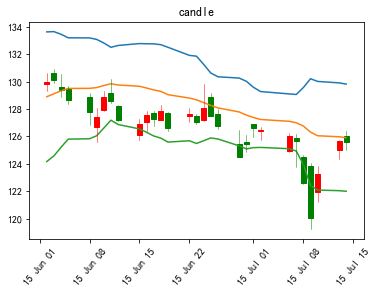

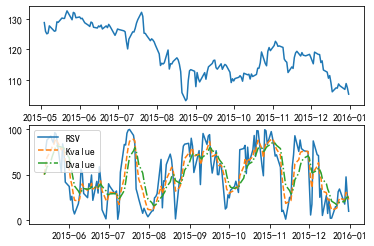


K值大于85或者D值大于20，超买
K值小于20或者D值小于20，超卖
J值大于100超买，小于0超卖
K与D的交叉也可以作为买卖信号



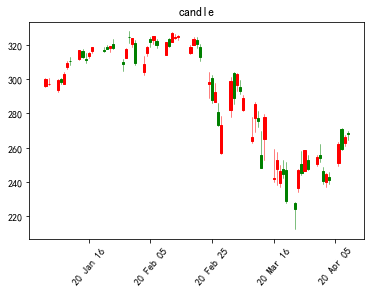

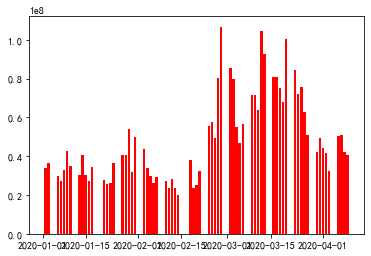

In [104]:
# 布林带函数（类似于正态分布的原理）
def bbands(tsPrice,period=20,times=2):
    upBBand=pd.Series(0.0,index=tsPrice.index)
    midBBand=pd.Series(0.0,index=tsPrice.index)
    downBBand=pd.Series(0.0,index=tsPrice.index)
    sigma=pd.Series(0.0,index=tsPrice.index)
    for i in range(period-1,len(tsPrice)):
        midBBand[i]=np.nanmean(tsPrice[i-(period-1):(i+1)])
        sigma[i]=np.nanstd(tsPrice[i-(period-1):(i+1)])
        upBBand[i]=midBBand[i]+times*sigma[i]
        downBBand[i]=midBBand[i]-times*sigma[i]
    BBands=pd.DataFrame({'upBBand':upBBand[(period-1):],\
                         'midBBand':midBBand[(period-1):],\
                         'downBBand':downBBand[(period-1):],\
                         'sigma':sigma[(period-1):]})
    return(BBands)
boll=bbands(dta_apple['Close'][1:50],20,2)
plt.plot(boll.iloc[:,[0,1,2]])
candlePlot(dta_apple.iloc[20:50,:]) # 20期
plt.show()

# KDJ
# RSV
close=dta_apple['Close']
high=dta_apple['High']
low=dta_apple['Low']
date=close.index.to_series()
ndate=len(date)
periodHigh=pd.Series(np.zeros(ndate-8),index=date.index[8:])
periodLow=pd.Series(np.zeros(ndate-8),index=date.index[8:])
RSV=pd.Series(np.zeros(ndate-8),index=date.index[8:])
for j in range(8,ndate):
    period=date[j-8:j+1]
    i=date[j]
    periodHigh[i]=high[period].max()
    periodLow[i]=low[period].min()
    RSV[i]=100*(close[i]-periodLow[i])\
           /(periodHigh[i]-periodLow[i])
RSV1=pd.Series([50,50],index=date[6:8]).append(RSV) # K、D初始值50
RSV1.name='RSV'
KValue=pd.Series(0.0,index=RSV1.index)
KValue[0]=50 # K、D初始值50
for i in range(1,len(RSV1)):
    KValue[i]=2/3*KValue[i-1]+RSV1[i]/3
KValue.name='KValue'
DValue=pd.Series(0.0,index=RSV1.index)
DValue[0]=50 # K、D初始值50
for i in range(1,len(RSV1)):
    DValue[i]=2/3*DValue[i-1]+KValue[i]/3
KValue=KValue[1:]
DValue.name='DValue'
DValue=DValue[1:]
JValue=3*KValue-2*DValue # J值

plt.subplot(211)
plt.plot(close['2015'])
plt.subplot(212)
plt.plot(RSV['2015'],label='RSV')
plt.plot(KValue['2015'],label='Kvalue',linestyle='dashed')
plt.plot(DValue['2015'],label='Dvalue',linestyle='-.')
plt.legend(loc='upper left')
plt.show()
print('''
K值大于85或者D值大于20，超买
K值小于20或者D值小于20，超卖
J值大于100超买，小于0超卖
K与D的交叉也可以作为买卖信号
''')

# 量价
# 以下为一般规律：
# 价涨量增（下跌行情中股价回升时，出现最佳）
# 价涨量平（反转信号，也有可能是市场调整期或者飞涨）
# 价涨量缩，一番调整，一批投资者被洗盘出局
# 价平量增，下跌行情中，利好信号，上涨行情中较少出现（更换庄家）
# 价平量缩，市场进行调整洗盘时
# 价跌量增，高位下跌初期（卖方多），下跌末期，买方多，但是不足以拉高价格
# 价跌量平，趋势不明，若跟在价平量平后面，考虑即时出逃
# 价跌量缩，一部分投资者逃离市场（正常现象）
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False  # 负号乱码，加上这一句
candlePlot(dta_apple['2020'])
plt.bar(dta_apple['Volume']['2020'].index,height=dta_apple['Volume']['2020'],label='Vol',color='r')
plt.show()
# 量价策略
# 计算价格和成交量的5日和10日简单移动平均值，当两者都释放买入信号时买入

# OBV指标(基于量价关系)
vol=dta_apple['Volume']
close=dta_apple['Close']
difclose=close.diff()
difclose[0]=0
OBV=(((difclose>=0)*2-1)*vol).cumsum()
OBV=smaCal(OBV,9) # OBV的值
AdjOBV=((close-dta_apple.Low)-(dta_apple.High-close))/(dta_apple.High-dta_apple.Low)*vol # 修正OBV的值
# OBV上升但是价格下降，买进信号
# OBV下降价格上升，可能要下跌
# OBV上升价格上升
# OBV下降价格下降，可能会继续下跌